# Gradient-based Model Inversion Attack against Federated Learning

In this tutorial, we will experiment gradient-based model inversion attack, which allows the malicious server of Federated Learning to reconstruct the private local dataset via the shared gradients. AIJack currently supports five gradient-based model inversion attacks. These methods reconstruct the private images by minimizing the distance between the fake gradients and the received gradients. Each method has its strategy, such as the distance metric and regularization terms.

In [1]:
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from numpy import e
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from aijack.attack import GradientInversion_Attack
from aijack.utils import NumpyDataset

import warnings
warnings.filterwarnings('ignore')

In [2]:
class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=768, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            nn.BatchNorm2d(12),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [3]:
def prepare_dataloader(path="MNIST/.", batch_size = 64, shuffle=True):
    at_t_dataset_train = torchvision.datasets.MNIST(
        root=path, train=True, download=True
    )

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    dataset = NumpyDataset(
        at_t_dataset_train.train_data.numpy(),
        at_t_dataset_train.train_labels.numpy(),
        transform=transform,
    )

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0
    )
    return dataloader

In [4]:
def attack_and_show(attacker, received_gradients, num_seeds):
  fig = plt.figure(figsize=(5, 2))
  for s in range(num_seeds):
      attacker.reset_seed(s)
      try:
        result = attacker.attack(received_gradients)
        ax = fig.add_subplot(1, num_seeds, s+1)
        ax.imshow(result[0].detach().numpy()[0][0], cmap="gray")
        ax.axis("off")
      except:
        continue
  plt.tight_layout()
  plt.show()

In [5]:
torch.manual_seed(7777)

shape_img = (28, 28)
num_classes = 10
channel = 1
hidden = 588

num_seeds=5

## Reconstruct Single Data

First, we try to recover the following private image from the received gradients with the batch size of 1.

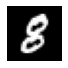

In [6]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
dataloader = prepare_dataloader()
for data in dataloader:
    xs, ys = data[0], data[1]
    break

x = xs[:1]
y = ys[:1]

fig = plt.figure(figsize=(1, 1))
plt.axis("off")
plt.imshow(x.detach().numpy()[0][0], cmap="gray")
plt.show()

In [7]:
criterion = nn.CrossEntropyLoss()
net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
pred = net(x)
loss = criterion(pred, y)
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

### DLG

https://dlg.mit.edu/assets/NeurIPS19_deep_leakage_from_gradients.pdf

- distance metric = L2 norm
- optimize labels

iter=81: loss did not improve in the last 50 rounds.
iter=72: loss did not improve in the last 50 rounds.
iter=66: loss did not improve in the last 50 rounds.
iter=72: loss did not improve in the last 50 rounds.
iter=69: loss did not improve in the last 50 rounds.


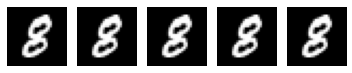

In [8]:
dlg_attacker = GradientInversion_Attack(net, (1, 28, 28), lr=1.0, log_interval=0,
                                        num_iteration=100, distancename="l2")
attack_and_show(dlg_attacker, received_gradients, num_seeds)

### GS Attack

https://arxiv.org/abs/2003.14053

- distance metric = cosine similarity
- optimize labels
- regularization: total-variance

iter=73: loss did not improve in the last 50 rounds.
iter=87: loss did not improve in the last 50 rounds.


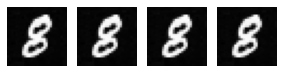

In [9]:
gs_attacker = GradientInversion_Attack(net, (1, 28, 28), lr=1.0, log_interval=0,
                                    num_iteration=100,
                                    tv_reg_coef=0.01,
                                    distancename="cossim")
attack_and_show(gs_attacker, received_gradients, num_seeds)

### iDLG Attack

https://arxiv.org/abs/2001.02610

- distance metric = L2 norm
- analytically estimate a label from the gradients

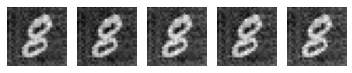

In [10]:
idlg_attacker = GradientInversion_Attack(net, (1, 28, 28), lr=10e2, log_interval=0,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    num_iteration=1000)
attack_and_show(idlg_attacker, received_gradients, num_seeds)

### CPL Attack

https://arxiv.org/abs/2004.10397

- distance metric = L2 norm
- analytically estimate an label from the gradients
- regularization: label-matching

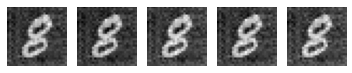

In [11]:
cpl_attacker = GradientInversion_Attack(net, (1, 28, 28), lr=10e2, log_interval=0,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    num_iteration=1000,
                                    lm_reg_coef=0.01)
attack_and_show(cpl_attacker, received_gradients, num_seeds)

## Reconstruct Batched Data

Second, we simulate the situatino with larger batch size. We try to recover the bellow three images.

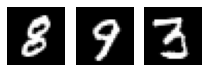

In [36]:
batch_size = 3
x_batch = xs[:batch_size]
y_batch = ys[:batch_size]

fig = plt.figure(figsize=(3, 2))
for bi in range(batch_size):
    ax = fig.add_subplot(1, batch_size, bi+1)
    ax.imshow(x_batch[bi].detach().numpy()[0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

### GradInversion

https://arxiv.org/abs/2104.07586

- distance metric = L2 norm
- analytically estimate labels from the gradients
- reguralization: total-variance, l2, bn, and group-consistency

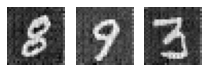

In [39]:
net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
pred = net(x_batch)
loss = criterion(pred, y_batch)
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

gradinversion = GradientInversion_Attack(net, (1, 28, 28), num_iteration=1000,
                                    lr=1e2, log_interval=0,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    bn_reg_layers=[net.body[1], net.body[4], net.body[7]],
                                    group_num = 5,
                                    tv_reg_coef=0.00, l2_reg_coef=0.0001,
                                    bn_reg_coef=0.001, gc_reg_coef=0.001)

result = gradinversion.group_attack(received_gradients, batch_size=batch_size)

fig = plt.figure(figsize=(3, 2))
for bid in range(batch_size):
    ax1 = fig.add_subplot(1, batch_size, bid+1)
    ax1.imshow((sum(result[0]) / len(result[0])).detach().numpy()[bid][0], cmap="gray")
    ax1.axis("off")
plt.tight_layout()
plt.show()